<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms
import shutil
import os
from google.colab import drive

In [30]:
def plot_avg_sale_prices_over_time(df, date_column='transaction_year_semi', price_column='transaction_price'):
    """
    Plots the average sale prices over time.

    Parameters:
    df (DataFrame): The dataset containing sales transactions.
    date_column (str): The column representing transaction year.
    price_column (str): The column representing sale price.
    """
    # Convert to DataFrame (if not already)
    df = pd.DataFrame(df)

    # Group by year and compute the average sale price
    avg_prices = df.groupby(date_column)[price_column].mean()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(avg_prices.index, np.log(avg_prices.values), marker='o', linestyle='-', color='blue', label="Average Sale Price")
    plt.xlabel("Year of Sale")
    plt.ylabel("Average Transaction Price")
    plt.title("Average Transaction Prices Over Time")
    plt.grid(True)
    plt.legend()

    plt.show()

def plot_categorical_features(data, categorical_columns):


    # Visualize distribution of categorical variables
    fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))

    for i, column in enumerate(categorical_columns):
        ax = axes[i]
        sns.countplot(x=column, data=data, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [31]:
def repeated_to_single_transactions(df):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """
    # Columns to keep (common info)
    common_columns = ['category', 'artist', 'height', 'width', 'medium']

    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house'
    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house'
    })

    final_df = pd.concat([sale_data, purchase_data], ignore_index=True)

    return final_df


def one_hot(data, vars):
  # one-hot encoding for various categorical variables
  df = data.copy()
  return pd.get_dummies(df, columns=vars).astype(int)


def data_filter(data, vars, min_price=5000):
    df = data.copy()
    df.dropna(axis=0, how='any', inplace=True)
    df = df[(df['transaction_price'] >= min_price) & (df['transaction_price'] < np.exp(16))]

    return df[vars]


In [ ]:
def data_split(data, selected_vars, one_hot_vars, date_filter):

    df = data.copy()
    df = repeated_to_single_transactions(df)
    df = data_filter(df, selected_vars)
    df = one_hot(df, one_hot_vars)



    # Identify the most recent dummy columns for the most recent semi-year
    #last_semi_year_cols = df.columns[-6:]  # Last four columns correspond to the most recent semi-year data

    # Split the data into training and testing sets based on the most recent semi-year columns
    #train_data = df[(df[last_semi_year_cols] == 0).all(axis=1)]  # Train set: all columns in the most recent semi-year should be 0
    #test_data = df[(df[last_semi_year_cols] == 1).any(axis=1)]   # Test set: at least one column in the most recent semi-year should be 1
    train_data = df[(df['transaction_year_semi'] < date_filter)]
    test_data = df[(df['transaction_year_semi'] >= date_filter)]

    # scale time variable
    train_data = train_data.copy()
    test_data = test_data.copy()

    # Fit on train, transform both
    scaler = MinMaxScaler()
    train_data['transaction_year_semi'] = scaler.fit_transform(train_data[['transaction_year_semi']])
    test_data['transaction_year_semi'] = scaler.transform(test_data[['transaction_year_semi']])


    # Prepare X and y for both training and testing
    X_train = train_data.drop(columns='transaction_price')
    y_train = np.log(train_data['transaction_price'])

    X_test = test_data.drop(columns='transaction_price')
    y_test = np.log(test_data['transaction_price'])

    # Ensure both X_train and X_test have the same columns (after dummy creation)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Specify numerical features that need scaling
    numerical_features = ['height', 'width']

    # Apply standardization to numerical features
    X_train, X_test = standardization(X_train, X_test, numerical_features)

    return X_train, X_test, y_train, y_test


def standardization(train, test, numerical_features):

    scaler = StandardScaler()
    train[numerical_features] = scaler.fit_transform(train[numerical_features])
    test[numerical_features] = scaler.transform(test[numerical_features])

    return train, test


In [32]:
class TransactionDataset(Dataset):

    def __init__(self, X, y):
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.reset_index(drop=True).values.astype('float32')  # Ensure float32 type
        self.y = y.reset_index(drop=True).values.astype('float32')  # Ensure float32 type

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Fetch one sample by index
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [33]:
def fit_visualization(X, y):
    target = np.array(X, dtype=np.float64)
    prediction_numerical_model = np.array(y, dtype=np.float64)

    # Compute R-squared using sklearn
    r_squared = r2_score(target, prediction_numerical_model)
    print(f"R-squared: {r_squared:.3f}")

    # Compute regression line parameters using linregress
    slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')

    # Plot the regression line
    plt.plot(target, slope * target + intercept, color='black', label=f'Regression Line (R²={r_squared:.3f})')

    # Plot y=x line (perfect predictions)
    plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Transaction Prices')
    plt.legend()

    # Annotate the regression equation on the plot
    equation_text = f"y = {slope:.3f}x + {intercept:.3f}"
    plt.text(min(target), max(prediction_numerical_model) * 0.9, equation_text, fontsize=12, color='black')

    # Show the plot
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


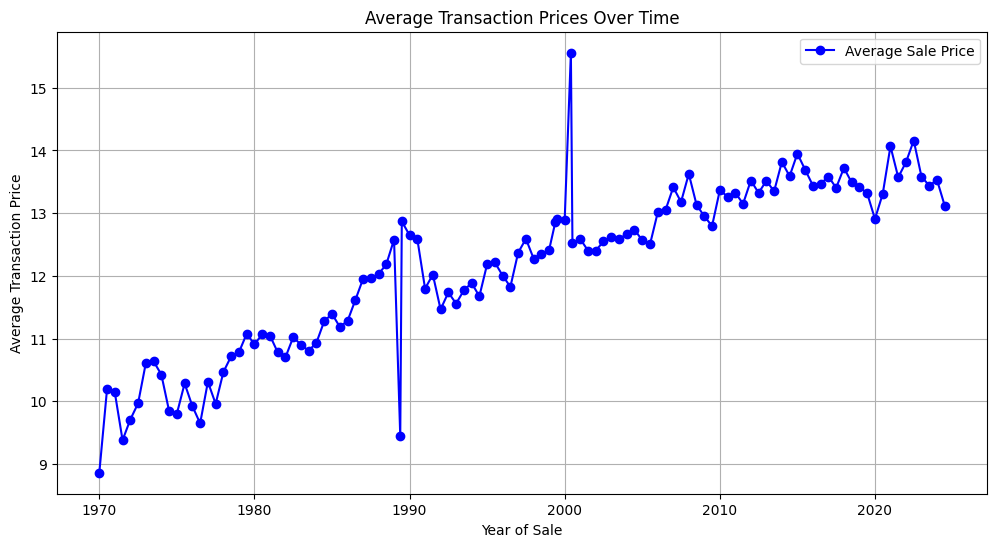

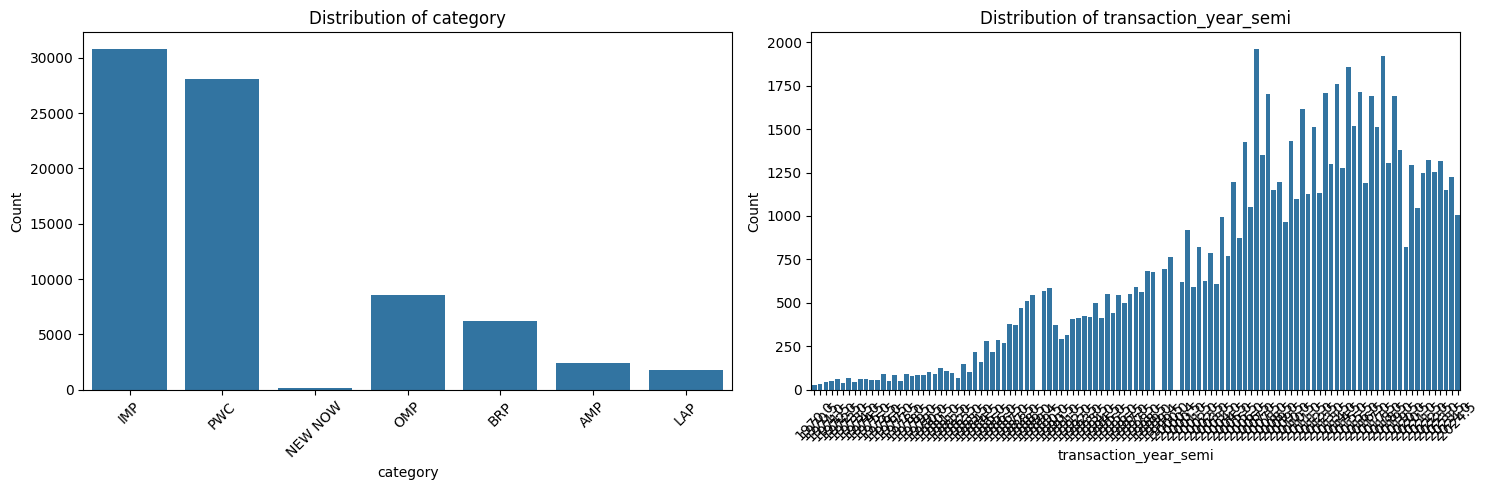

In [34]:
if __name__ == "__main__":


  drive.mount('/content/drive')
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # Define source and destination paths
  source_path = "/content/drive/My Drive/Colab Notebooks/data_prep.ipynb"
  destination_path = "/content/drive/My Drive/data_prep.ipynb"

  # Check if the source file exists before moving
  if os.path.exists(source_path):
    # Move the file
    shutil.move(source_path, destination_path)
    print(f"Notebook moved to: {destination_path}")

  # visualizations
  visualization_data = repeated_to_single_transactions(artwork_numeric_data)
  plot_avg_sale_prices_over_time(visualization_data)
  categorical_columns = ['category', 'transaction_year_semi']
  plot_categorical_features(visualization_data, categorical_columns)




